# Project

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt

%matplotlib inline

In [2]:
# set the font size
import matplotlib
font = {'family' : 'sans-serif',
        'weight' : 'normal',
        'size'   : 17}

matplotlib.rc('font', **font)

## retail 1

Import the table for retail 1.

In [3]:
DateConverter = lambda d : dt.datetime.strptime(d.decode('utf-8'),\
                                                           '%m/%d/%Y %H:%M')
retail1 = np.genfromtxt('building1retail.csv',delimiter=",",\
            dtype=[('timestamp', type(dt.datetime.now)),('OATF', 'f8'),('PowerkW', 'f8')],\
            converters={0: DateConverter}, skip_header=1)

Check the timestamps gaps.

In [4]:
print("The minimum difference between any two consecutive timestamps is: " +\
      str(np.min(np.diff(retail1['timestamp']))) )
print("The maximum difference between any two consecutive timestamps is: " +\
      str(np.max(np.diff(retail1['timestamp']))) )   

The minimum difference between any two consecutive timestamps is: 0:15:00
The maximum difference between any two consecutive timestamps is: 0:15:00


Check the start date and end date of retail 1 dataset.

In [5]:
print("First timestamp is on \t{}. \nLast timestamp is on \t{}.".format(\
            retail1['timestamp'][0], retail1['timestamp'][-1]))

First timestamp is on 	2010-01-01 01:15:00. 
Last timestamp is on 	2010-12-31 00:00:00.


In [6]:
timestamp = retail1['timestamp']
temperature = retail1['OATF']
power = retail1['PowerkW']
data_retail1 = np.vstack((timestamp, power, temperature)).T

Plot the electric load changes with time in a whole year.

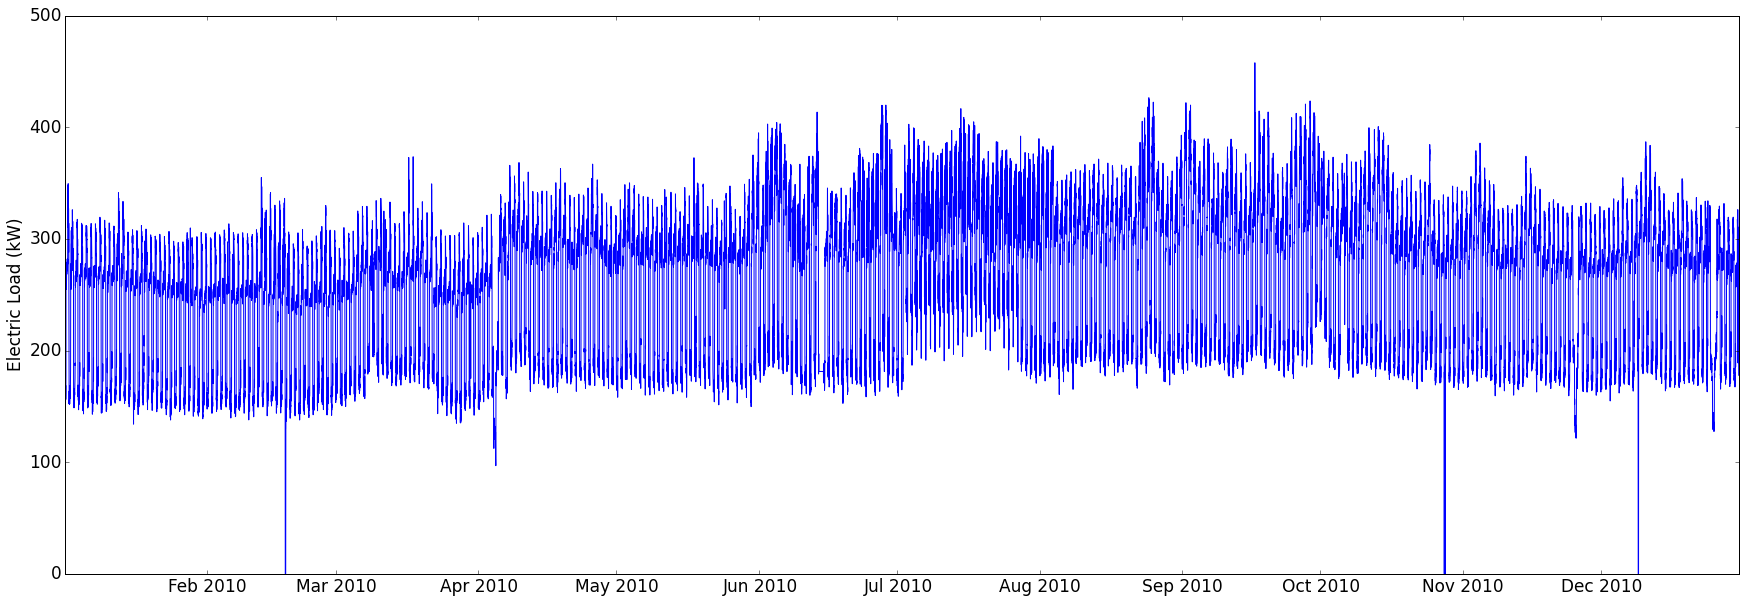

In [7]:
plt.figure(figsize=(30,10))
plt.plot(timestamp, power)
plt.ylabel('Electric Load (kW)')

Plot the electric load changes with time in two weeks period.

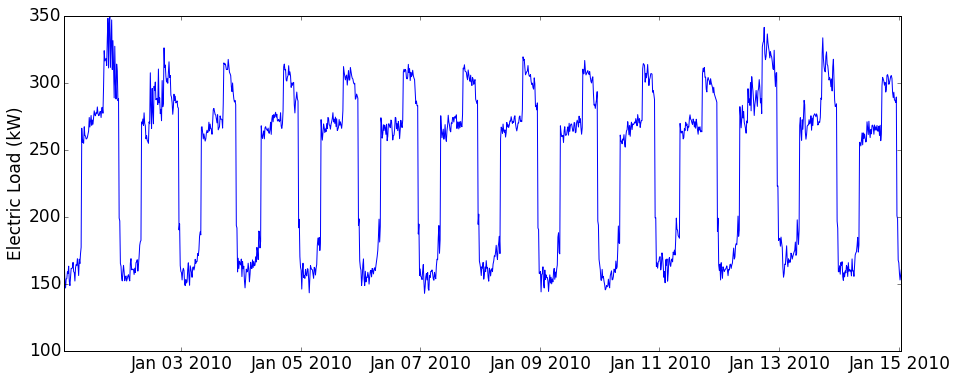

In [10]:
plt.figure(figsize=(15,6))
plt.plot(timestamp[:1344], power[:1344])
plt.ylabel('Electric Load (kW)')

Plot the electric load with temperature.

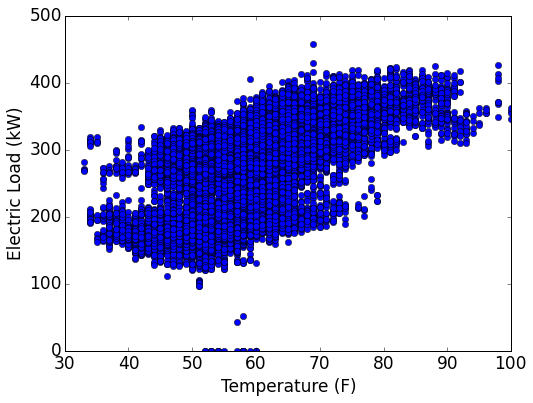

In [11]:
plt.figure(figsize=(8,6))
plt.plot(temperature, power, 'bo')
plt.xlabel('Temperature (F)')
plt.ylabel('Electric Load (kW)')

Divide all data points into two parts, occupied time and unoccupied time. All days are occupied day because retail opens every day including weekends. Occupied hours can be found by ploting box plot.

In [12]:
weekday = list(map(lambda t: t.weekday(), timestamp))
## Note that depending on how you do this, the result could be a tuple of ndarrays.
weekdays = np.where(np.array(weekday) <= 7)

In [13]:
hour = list(map(lambda t: t.hour, timestamp))
# we consider 8am to 6pm in weekdays as occupied and others as unoccupied
occupied = np.where(np.all([np.array(hour) >= 7,np.array(hour) < 18], axis=0))
unoccupied = np.where(np.any([np.array(hour) < 7,np.array(hour) >= 18],axis=0))

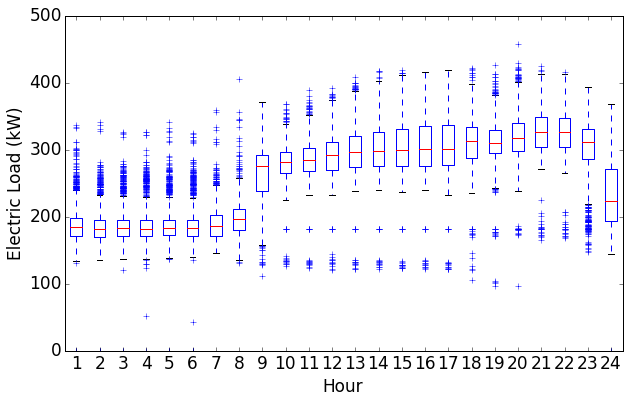

In [15]:
data_weekdays = data_retail1[weekdays]
plt.figure(figsize=(10,6))
plt.boxplot([[data_weekdays[np.where(np.array([t.hour for t in data_weekdays[:,0]]\
                                             )==i)[0],1]] for i in range(24)])
plt.xlabel('Hour')
plt.ylabel('Electric Load (kW)')

It seems a better choice is to pick 9am-11pm.

In [16]:
hour = list(map(lambda t: t.hour, timestamp))
# we consider 9am to 11pm in weekdays as occupied and others as unoccupied
occupied = np.where(np.all([np.array(hour) >= 8,np.array(hour) < 23],axis=0))
unoccupied = np.where(np.any([np.array(hour) < 8,np.array(hour) >= 23],axis=0))

Plot electric load with temperature in occupied time and unoccupied time.

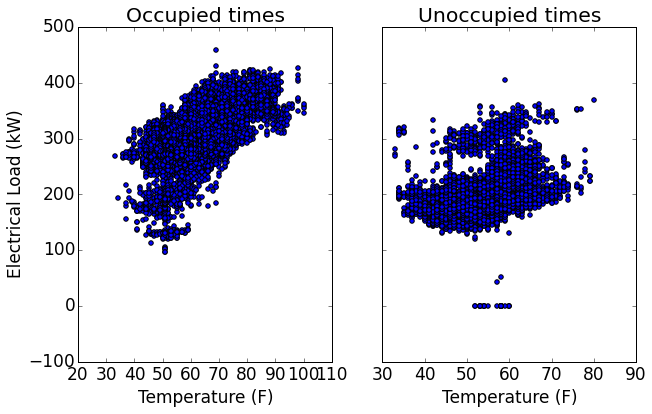

In [19]:
# plt.figure()
f, (ax1, ax2) = plt.subplots(1,2,sharey=True,figsize=(10,6))
ax1.scatter(data_retail1[occupied[0],2],data_retail1[occupied[0],1])
ax1.set_title('Occupied times')
ax1.set_ylabel('Electrical Load (kW)')
ax1.set_xlabel('Temperature (F)')
ax2.scatter(data_retail1[unoccupied[0],2],data_retail1[unoccupied[0],1])
ax2.set_title('Unoccupied times')
# ax1.set_ylabel('Electrical Power (kW)')
ax2.set_xlabel('Temperature (F)')

Do a regression to occupied times.

In [20]:
def Tc(temperature, T_bound):
    # The return value will be a matrix with as many rows as the temperature
    # array, and as many columns as len(T_bound) [assuming that 0 is the first boundary]
    
    Tc_matrix = np.zeros((len(temperature), len(T_bound)+1))
    
    for (i,t) in enumerate(temperature):
        # first chunk
        if t <= T_bound[0]:
            Tc_matrix[i,0] = t
            continue
        else:
            Tc_matrix[i,0] = T_bound[0]
       
        # chunks in the middle
        n = 1
        while(n < len(T_bound)-1 and t > T_bound[n]):
            Tc_matrix[i,n] = T_bound[n+1] - T_bound[n]
            n += 1
        if(n < len(T_bound) and t <= T_bound[n]):
            Tc_matrix[i,n] = t - T_bound[n-1]
            continue
        
        # last chunk
        if(t > T_bound[-1]):
            if(len(T_bound)>1):
                Tc_matrix[i,-2] = T_bound[-1] - T_bound[-2]
            Tc_matrix[i,-1] = t - T_bound[-1]
    
    return Tc_matrix

In [21]:
def DesignMatrix(temperature, T_bound, dim):
    
    # dim represents how many data points you want to count as one sample
    # in the case of the paper, dim=480
    m = len(temperature)
    # check if the input is valid
    if np.mod(m,dim) != 0:
        print('Invalid dimension, the number of points is %d but the dimension is %d.'\
             % (m,dim))
        print('The number of points should be integer multiple of the dimension size.')
        print('Please try again with vlaid arguments.')
        return
    num_sample = m//dim
    num_chunks = len(T_bound) + 1
    
    DM = np.zeros((len(temperature) ,  dim + num_chunks))
    
    # first column ones representing intercept
    # DM[:,0] = np.ones(m)
    # repeat identify matrix of dim
    DM[:,0:-num_chunks] = np.vstack([np.eye(dim)] * num_sample)
    # append Tc at end
    DM[:,-num_chunks:] = Tc(temperature, T_bound)
    
    return DM

In [22]:
def beta_hat(X, power_values):
    # check rank of X to see if it's valid
#     from numpy.linalg import matrix_rank
    mr = np.linalg.matrix_rank(X)
    min_dim = min(X.shape)
    if mr < min_dim:
        print('Singular Matrix Warning: matrix rank %d but the minimum dimension %d'\
             % (mr, min_dim))
    # use formula to calculate beta, instead of using inverse, we use pseudo inverse
    return np.linalg.inv(np.dot(X.T,X)).dot(X.T).dot(power_values)

In [24]:
# the code to use weekdays Mon-Fri
# dim = 4*24*5 
# data_weekday = data[weekdays]

# the code to use occupied Mon-Fri, 9am-11pm
dim = 4*14*5 
data_weekday = data_retail1[occupied]

num_point = len(data_weekday)


print('Total points:%d, number of points per sample:%d'\
     % (num_point, dim))
truncated_point = num_point//dim * dim
print('To make sure we have integer samples,we need to runcated points to %d'\
     % truncated_point )
print('We have %d samples, each sample has %d points'\
     % (truncated_point/dim, dim))

Total points:21840, number of points per sample:280
To make sure we have integer samples,we need to runcated points to 21840
We have 78 samples, each sample has 280 points


In [26]:
data_weekday = data_retail1[:truncated_point]

trainData = data_weekday[:truncated_point//dim//2*dim]
testData = data_weekday[truncated_point//dim//2*dim:]

In [28]:
T_bound = np.array([ 45.,  52.,  59.,  66.,  73.])
DM = DesignMatrix(trainData[:,2], T_bound, dim)
beta_train = beta_hat(DM,trainData[:,1])
predicted = DesignMatrix(testData[:,2], T_bound, dim).dot(beta_train)

Plot the prediction and real electric load.

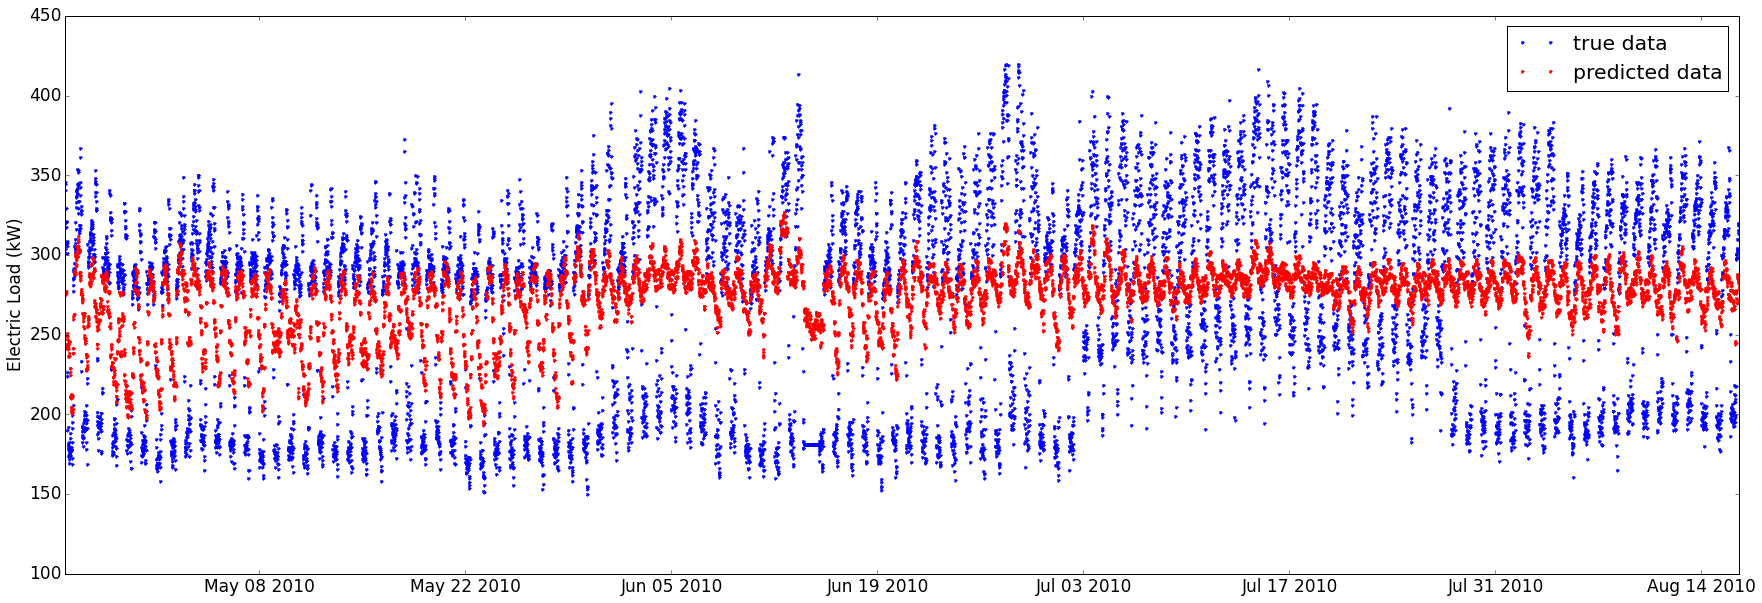

In [30]:
plt.figure(figsize=(30,10))
plt.plot(testData[:,0],testData[:,1],'.b')
plt.plot(testData[:,0],predicted,'.r')
plt.legend(['true data','predicted data'])
plt.ylabel('Electric Load (kW)')

Calculate R square

In [31]:
actualPower = testData[:,1]
y_average = np.ones(len(actualPower))
for i in range(len(actualPower)):
    y_average[i] = np.mean(actualPower)

In [32]:
X_test = DesignMatrix(testData[:,2], T_bound, dim)
bh = beta_train
a = actualPower - np.dot(X_test, bh)
b = np.dot(np.transpose(a), a)
c = actualPower - y_average
d = np.dot(np.transpose(c), c)
R_square = 1 - (b/d)
R_square

0.3156153695530195

In [33]:
bh

array([68.39490178648279, 67.02310675537771, 69.87182470402328,
       69.14105547325407, 74.53022753033075, 74.71997112007413,
       75.17381727392085, 73.72253522263831, 67.66050908368572,
       65.88871421189057, 65.23230395548094, 65.58358600676235,
       72.60708597472315, 74.62247059010767, 72.48400905164614,
       71.11221417985121, 67.47808085910204, 67.09346547448668,
       66.03705521807684, 68.13705521807663, 74.61222681495276,
       73.96094476367053, 72.14043194315786, 71.29684219956826,
       67.02073876396928, 66.89766184089241, 66.7361233793547,
       68.6668926101235, 76.07773077676312, 75.7290128280453,
       76.26491026394264, 75.86491026394255, 72.3801253117143,
       72.47499710658585, 67.81089454248327, 69.89807402966258,
       78.16015152124601, 77.54220280329724, 79.01912588022074,
       76.86015152124637, 71.01364421735853, 71.21877242248644,
       68.22646473017895, 69.43415703787113, 78.89005429876904,
       78.31056711928177, 77.68749019620454,

## retail 2

The same way import retail 2 dataset.

In [34]:
retail2 = np.genfromtxt('building2retail.csv',delimiter=",",\
            dtype=[('timestamp', type(dt.datetime.now)),('OATF', 'f8'),('PowerkW', 'f8')],\
            converters={0: DateConverter}, skip_header=1)

In [36]:
print("The minimum difference between any two consecutive timestamps is: " +\
      str(np.min(np.diff(retail2['timestamp']))) )
print("The maximum difference between any two consecutive timestamps is: " +\
      str(np.max(np.diff(retail2['timestamp']))) )     

The minimum difference between any two consecutive timestamps is: 0:15:00
The maximum difference between any two consecutive timestamps is: 0:15:00


In [38]:
print("First timestamp is on \t{}. \nLast timestamp is on \t{}.".format(\
            retail2['timestamp'][0], retail2['timestamp'][-1]))

First timestamp is on 	2010-01-01 01:15:00. 
Last timestamp is on 	2010-12-31 00:00:00.


In [39]:
timestamp = retail2['timestamp']
temperature = retail2['OATF']
power = retail2['PowerkW']
data_retail2 = np.vstack((timestamp, power, temperature)).T

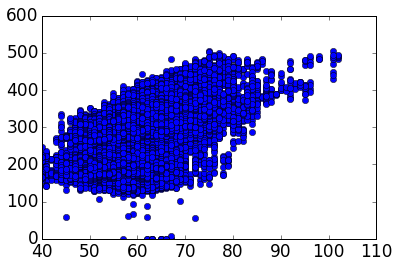

In [40]:
plt.plot(temperature, power, 'bo')

In [41]:
weekday = list(map(lambda t: t.weekday(), timestamp))
## Note that depending on how you do this, the result could be a tuple of ndarrays.
weekdays = np.where(np.array(weekday) <= 7)
hour = list(map(lambda t: t.hour, timestamp))
# we consider 8am to 6pm in weekdays as occupied and others as unoccupied
occupied = np.where(np.all([np.array(hour) >= 7,np.array(hour) < 18], axis=0))
unoccupied = np.where(np.any([np.array(hour) < 7,np.array(hour) >= 18],axis=0))

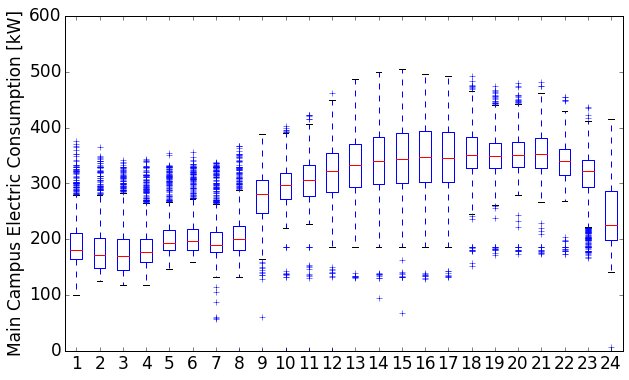

In [44]:
data_weekdays = data_retail2[weekdays]
plt.figure(figsize=(10,6))
plt.boxplot([[data_weekdays[np.where(np.array([t.hour for t in data_weekdays[:,0]]\
                                             )==i)[0],1]] for i in range(24)])
plt.ylabel('Main Campus Electric Consumption [kW]')

In [45]:
hour = list(map(lambda t: t.hour, timestamp))
# we consider 9am to 11pm in weekdays as occupied and others as unoccupied
occupied = np.where(np.all([np.array(hour) >= 8,np.array(hour) < 23],axis=0))
unoccupied = np.where(np.any([np.array(hour) < 8,np.array(hour) >= 23],axis=0))

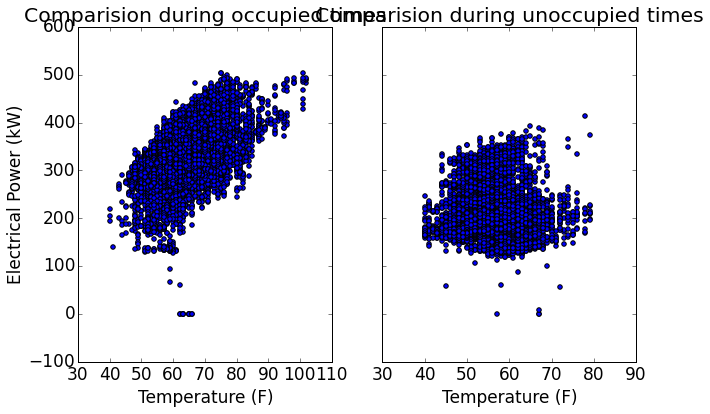

In [48]:
# plt.figure()
f, (ax1, ax2) = plt.subplots(1,2,sharey=True,figsize=(10, 6))
ax1.scatter(data_retail2[occupied[0],2],data_retail2[occupied[0],1])
ax1.set_title('Comparision during occupied times')
ax1.set_ylabel('Electrical Power (kW)')
ax1.set_xlabel('Temperature (F)')
ax2.scatter(data_retail2[unoccupied[0],2],data_retail2[unoccupied[0],1])
ax2.set_title('Comparision during unoccupied times')
# ax1.set_ylabel('Electrical Power (kW)')
ax2.set_xlabel('Temperature (F)')

In [50]:
dim = 4*14*5 
data_weekday = data_retail2[occupied]

num_point = len(data_weekday)


print('Total points:%d, number of points per sample:%d'\
     % (num_point, dim))
truncated_point = num_point//dim * dim
print('To make sure we have integer samples,we need to runcated points to %d'\
     % truncated_point )
print('We have %d samples, each sample has %d points'\
     % (truncated_point/dim, dim))

Total points:21840, number of points per sample:280
To make sure we have integer samples,we need to runcated points to 21840
We have 78 samples, each sample has 280 points


In [52]:
data_weekday = data_retail2[:truncated_point]

trainData = data_weekday[:truncated_point//dim//2*dim]
testData = data_weekday[truncated_point//dim//2*dim:]

In [53]:
# get T_bound
num_chunk = 6

T_bound = np.linspace(min(data_weekday[:,2]),max(data_weekday[:,2]),num_chunk+1)[1:-1]

In [54]:
DM = DesignMatrix(trainData[:,2], T_bound, dim)
beta_train = beta_hat(DM,trainData[:,1])
predicted = DesignMatrix(testData[:,2], T_bound, dim).dot(beta_train)

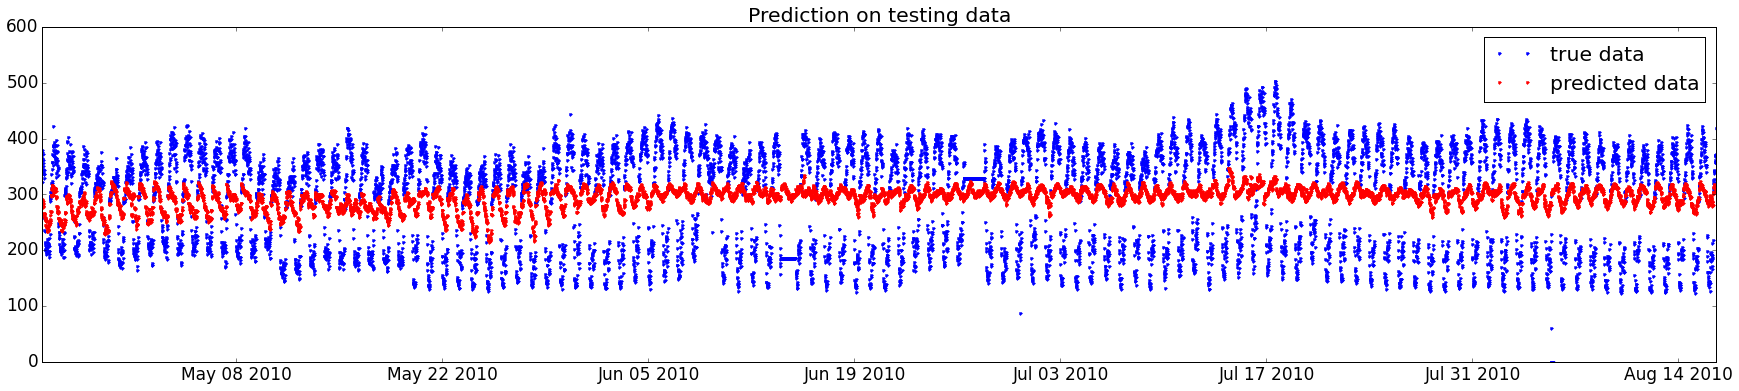

In [57]:
plt.figure(figsize=(30,6))
plt.plot(testData[:,0],testData[:,1],'.b')
plt.plot(testData[:,0],predicted,'.r')
plt.legend(['true data','predicted data'])
plt.title('Prediction on testing data')

In [58]:
actualPower = testData[:,1]
y_average = np.ones(len(actualPower))
for i in range(len(actualPower)):
    y_average[i] = np.mean(actualPower)

In [59]:
X_test = DesignMatrix(testData[:,2], T_bound, dim)
bh = beta_train
a = actualPower - np.dot(X_test, bh)
b = np.dot(np.transpose(a), a)
c = actualPower - y_average
d = np.dot(np.transpose(c), c)
R_square = 1 - (b/d)
R_square

0.14379476230658417

In [60]:
bh

array([128.15556690829266, 129.64018225315573, 124.17607968957374,
       125.49659251008629, 123.79631328826113, 130.9527235446703,
       128.9116979036435, 131.52964662159283, 126.81337456966021,
       123.9569643132496, 123.16722072350628, 121.47234892863446,
       122.99775038798388, 123.39005808029172, 122.7054426956763,
       123.55928884952293, 119.9276654871499, 121.85074241022652,
       116.05587061535512, 116.04048599997175, 121.14078271166244,
       122.27155194243166, 119.66898783986652, 118.94591091678966,
       115.28479577996389, 114.52582142099014, 112.08992398509245,
       115.67966757483613, 124.89206798292648, 125.52540131625922,
       123.17924747010564, 123.02283721369612, 117.77297839182864,
       119.89349121234129, 116.87297839183005, 118.04477326362418,
       123.98517338803177, 124.51850672136639, 123.9159426188015,
       121.58260928546835, 119.45782958946955, 118.18090651254677,
       119.11167574331512, 119.12193215357235, 127.96491243254427,
 

## retail 4

The same way import retail 4.

In [61]:
retail4 = np.genfromtxt('building4retail.csv',delimiter=",",\
            dtype=[('timestamp', type(dt.datetime.now)),('OATF', 'f8'),('PowerkW', 'f8')],\
            converters={0: DateConverter}, skip_header=1)

In [62]:
print("The minimum difference between any two consecutive timestamps is: " +\
      str(np.min(np.diff(retail4['timestamp']))) )
print("The maximum difference between any two consecutive timestamps is: " +\
      str(np.max(np.diff(retail4['timestamp']))) ) 

The minimum difference between any two consecutive timestamps is: 0:15:00
The maximum difference between any two consecutive timestamps is: 0:15:00


In [63]:
print("First timestamp is on \t{}. \nLast timestamp is on \t{}.".format(\
            retail4['timestamp'][0], retail4['timestamp'][-1]))

First timestamp is on 	2010-01-01 01:15:00. 
Last timestamp is on 	2010-12-31 00:00:00.


In [64]:
timestamp = retail4['timestamp']
temperature = retail4['OATF']
power = retail4['PowerkW']
data_retail4 = np.vstack((timestamp, power, temperature)).T

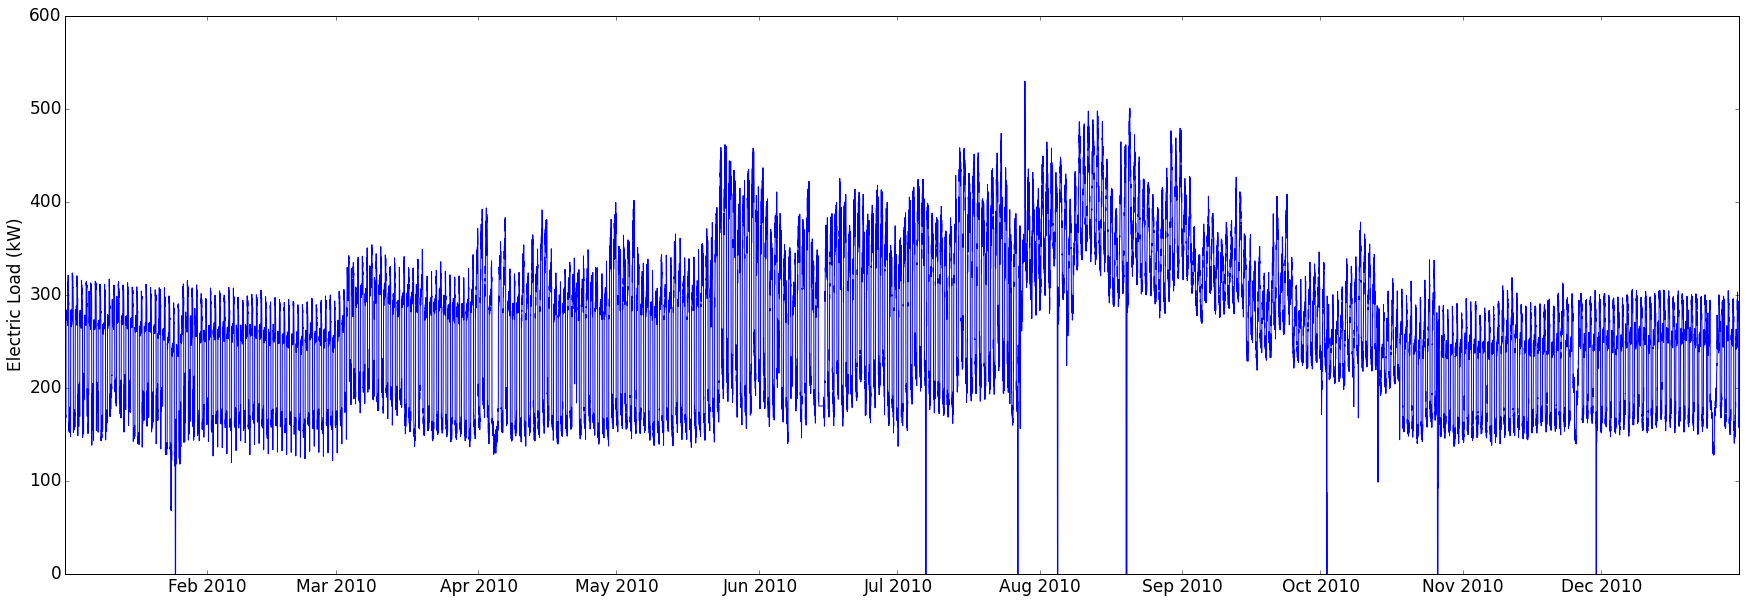

In [65]:
plt.figure(figsize=(30,10))
plt.plot(timestamp, power)
plt.ylabel('Electric Load (kW)')

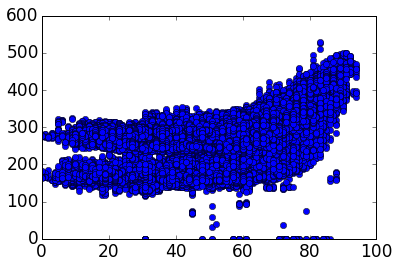

In [66]:
plt.plot(temperature, power, 'bo')

In [67]:
weekday = list(map(lambda t: t.weekday(), timestamp))
## Note that depending on how you do this, the result could be a tuple of ndarrays.
weekdays = np.where(np.array(weekday) <= 7)

In [68]:
hour = list(map(lambda t: t.hour, timestamp))
# we consider 8am to 6pm in weekdays as occupied and others as unoccupied
occupied = np.where(np.all([np.array(hour) >= 7,np.array(hour) < 18], axis=0))
unoccupied = np.where(np.any([np.array(hour) < 7,np.array(hour) >= 18],axis=0))

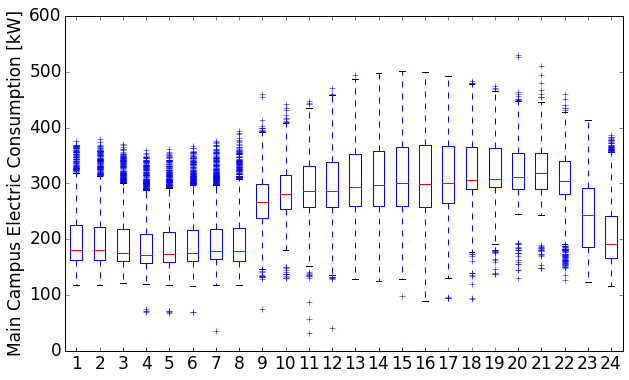

In [73]:
data_weekdays = data_retail4[weekdays]
plt.figure(figsize=(10,6))
plt.boxplot([[data_weekdays[np.where(np.array([t.hour for t in data_weekdays[:,0]]\
                                             )==i)[0],1]] for i in range(24)])
plt.ylabel('Main Campus Electric Consumption [kW]')

In [74]:
hour = list(map(lambda t: t.hour, timestamp))
# we consider 9am to 11pm in weekdays as occupied and others as unoccupied
occupied = np.where(np.all([np.array(hour) >= 8,np.array(hour) < 23],axis=0))
unoccupied = np.where(np.any([np.array(hour) < 8,np.array(hour) >= 23],axis=0))

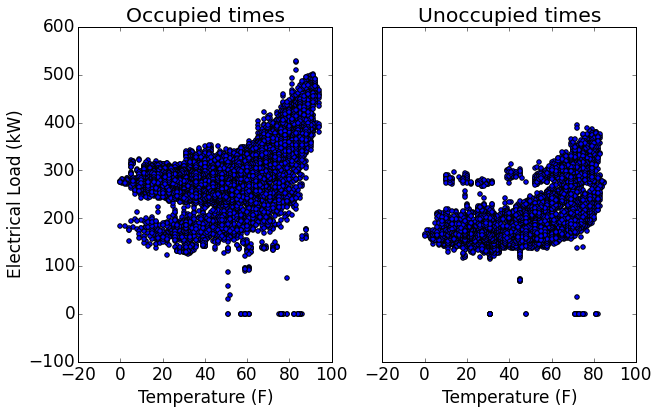

In [75]:
# plt.figure()
f, (ax1, ax2) = plt.subplots(1,2,sharey=True,figsize=(10,6))
ax1.scatter(data_retail4[occupied[0],2],data_retail4[occupied[0],1])
ax1.set_title('Occupied times')
ax1.set_ylabel('Electrical Load (kW)')
ax1.set_xlabel('Temperature (F)')
ax2.scatter(data_retail4[unoccupied[0],2],data_retail4[unoccupied[0],1])
ax2.set_title('Unoccupied times')
# ax1.set_ylabel('Electrical Power (kW)')
ax2.set_xlabel('Temperature (F)')

In [77]:
dim = 4*14*5 
data_weekday = data_retail4[occupied]

num_point = len(data_weekday)


print('Total points:%d, number of points per sample:%d'\
     % (num_point, dim))
truncated_point = num_point//dim * dim
print('To make sure we have integer samples,we need to runcated points to %d'\
     % truncated_point )
print('We have %d samples, each sample has %d points'\
     % (truncated_point/dim, dim))

Total points:21840, number of points per sample:280
To make sure we have integer samples,we need to runcated points to 21840
We have 78 samples, each sample has 280 points


In [79]:
data_weekday = data_retail4[:truncated_point]

trainData = data_weekday[:truncated_point//dim//2*dim]
testData = data_weekday[truncated_point//dim//2*dim:]

In [80]:
num_chunk = 6

T_bound = np.linspace(min(data_weekday[:,2]),max(data_weekday[:,2]),num_chunk+1)[1:-1]

In [81]:
DM = DesignMatrix(trainData[:,2], T_bound, dim)
beta_train = beta_hat(DM,trainData[:,1])
predicted = DesignMatrix(testData[:,2], T_bound, dim).dot(beta_train)

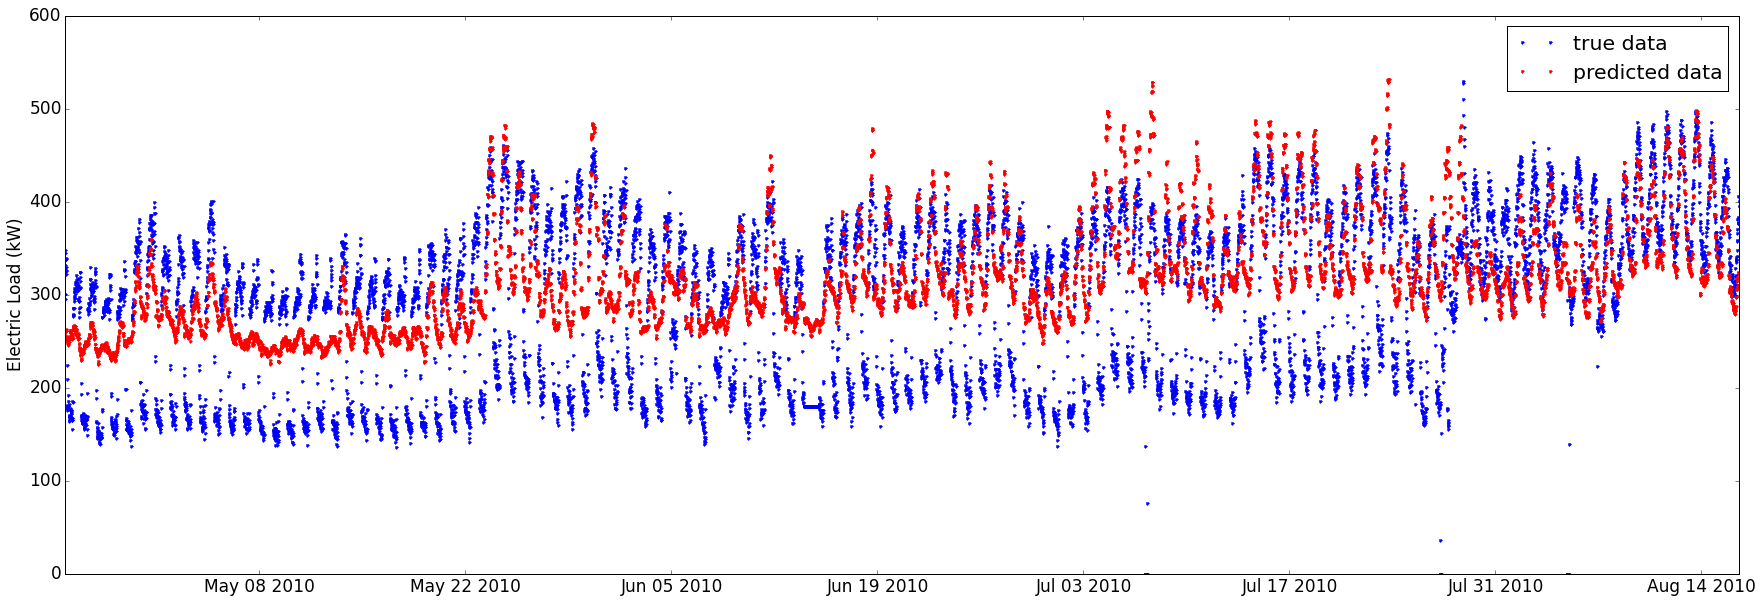

In [82]:
plt.figure(figsize=(30,10))
plt.plot(testData[:,0],testData[:,1],'.b')
plt.plot(testData[:,0],predicted,'.r')
plt.legend(['true data','predicted data'])
plt.ylabel('Electric Load (kW)')

In [83]:
actualPower = testData[:,1]
y_average = np.ones(len(actualPower))
for i in range(len(actualPower)):
    y_average[i] = np.mean(actualPower)

In [84]:
X_test = DesignMatrix(testData[:,2], T_bound, dim)
bh = beta_train
a = actualPower - np.dot(X_test, bh)
b = np.dot(np.transpose(a), a)
c = actualPower - y_average
d = np.dot(np.transpose(c), c)
R_square = 1 - (b/d)
R_square

0.38577243770594116

In [85]:
bh

array([205.82351125891518, 204.8465881876051, 205.3337676747839,
       204.36710100811717, 203.13556946568204, 205.04582587593853,
       202.49454382465646, 201.98941561952836, 205.29529423420396,
       205.2363198752296, 206.70042243933196, 206.24657628548593,
       206.10123998258612, 205.8499579313042, 202.65252203386822,
       202.42175280309914, 203.21894127515748, 204.66765922387535,
       206.1445823007985, 206.82919768541393, 207.50759719895652,
       204.08452027587967, 202.31016130152082, 201.23836642972597,
       203.6030240942035, 203.8722548634344, 205.9568702480498,
       206.1286651198447, 210.49881473233708, 209.23214806567051,
       206.11419934772158, 206.70394293746526, 208.87255765032967,
       209.454608932381, 209.7725576503298, 209.84691662468884,
       213.6038664869276, 213.37566135872257, 211.99361007667125,
       212.02181520487648, 212.5283585351005, 211.77451238125434,
       211.22323032997232, 209.9668200735621, 211.90392966524266,
       211

## office 1

In [86]:
office1 = np.genfromtxt('building61duringoffice.csv',delimiter=",",\
            dtype=[('date', type(dt.datetime.now)),('OAT', 'f8'),('Building 6 kW', 'f8')],\
            converters={0: DateConverter}, skip_header=1)

In [88]:
print("The minimum difference between any two consecutive timestamps is: " +\
      str(np.min(np.diff(office1['date']))) )
print("The maximum difference between any two consecutive timestamps is: " +\
      str(np.max(np.diff(office1['date']))) )    

The minimum difference between any two consecutive timestamps is: 1:00:00
The maximum difference between any two consecutive timestamps is: 1:00:00


In [90]:
print("First timestamp is on \t{}. \nLast timestamp is on \t{}.".format(\
            office1['date'][0], office1['date'][-1]))

First timestamp is on 	2010-01-01 00:00:00. 
Last timestamp is on 	2010-12-31 23:00:00.


In [93]:
timestamp = office1['date']
temperature = office1['OAT']
power = office1['Building_6_kW']
data_office1 = np.vstack((timestamp, power, temperature)).T

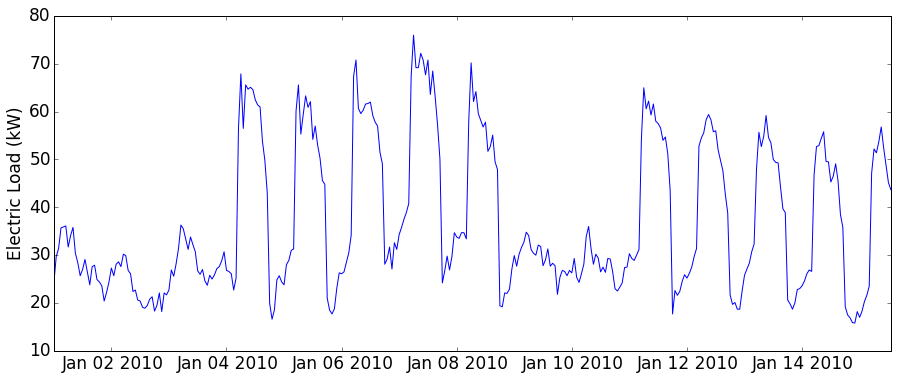

In [96]:
plt.figure(figsize=(15, 6))
plt.plot(timestamp[:350], power[:350])
plt.ylabel('Electric Load (kW)')

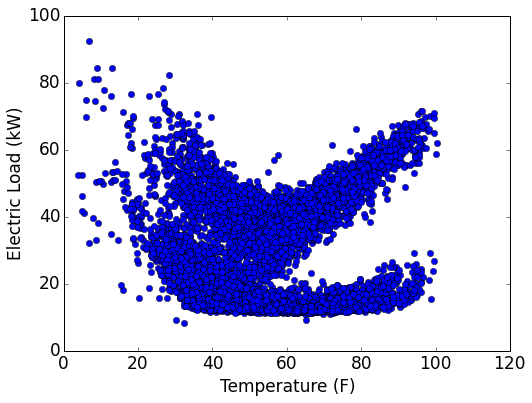

In [97]:
plt.figure(figsize=(8,6))
plt.plot(temperature, power, 'bo')
plt.xlabel('Temperature (F)')
plt.ylabel('Electric Load (kW)')